In [1]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
import warnings
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
import json

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
dataset_map = {
    '1': 'Energy',
    '2': 'Stock',
    '3': 'Traffic',
    '4': 'Weather'
}
dataset_choice = input("Select dataset (1. Energy 2. Stock 3. Traffic 4. Weather): ")
selected_dataset = dataset_map.get(dataset_choice)

Select dataset (1. Energy 2. Stock 3. Traffic 4. Weather):  2


In [4]:
base_models = ['LSTM', 'Transformer', 'LiquidML', 'XGBoost']
selected_models = []
for model in base_models:
    choice = input(f"Include {model} in ensemble? (y/n): ")
    if choice.lower() == 'y':
        selected_models.append(model)

Include LSTM in ensemble? (y/n):  y
Include Transformer in ensemble? (y/n):  y
Include LiquidML in ensemble? (y/n):  y
Include XGBoost in ensemble? (y/n):  y


In [5]:
dataset_files = {
    'Energy': '../datasets/AEP_hourly_processed.xlsx',
    'Stock': '../datasets/Tesla_Stock.xlsx',
    'Traffic': '../datasets/traffic.xlsx',
    'Weather': '../datasets/jena_climate.xlsx'
}

selected_file = dataset_files[selected_dataset]

In [6]:
def split_target_series(y):
    split_idx = int(len(y) * 0.8)
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    return y_train, y_test

In [7]:
X_train_meta, X_test_meta = [], []

for model in selected_models:
    X_train_meta.append(np.load(f"../{model}/predictions/{selected_dataset}_{model}_train.npy").reshape(-1))
    X_test_meta.append(np.load(f"../{model}/predictions/{selected_dataset}_{model}_test.npy").reshape(-1))

X_train_meta = np.stack(X_train_meta, axis=1)
X_test_meta = np.stack(X_test_meta, axis=1)

In [8]:
df = pd.read_excel(selected_file)
target_column = None

if (selected_dataset == "Energy"):
    target_column = "AEP_MW"
    df = df.iloc[:5000]
elif (selected_dataset == "Stock"):
    target_column = "Close"
    df = df.iloc[-2000:]
elif (selected_dataset == "Traffic"):
    target_column = "Vehicles"
    df = df.iloc[-3000:]
else:
    target_column = "Tpot (K)"
    df = df.iloc[::144]

full_target = df[target_column].values

split_idx = int(len(full_target) * 0.8)
y_train = full_target[:split_idx]
y_train = y_train[60:]
y_test = full_target[split_idx:]
y_test = y_test[60:]

In [9]:
meta_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_meta_scaled = meta_scaler.fit_transform(X_train_meta)
X_test_meta_scaled = meta_scaler.transform(X_test_meta)

y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [10]:
def weighted_rmse(weights):
    weights = np.array(weights)
    weights /= weights.sum()
    blended_preds_scaled = np.dot(X_test_meta_scaled, weights)
    blended_preds = target_scaler.inverse_transform(blended_preds_scaled.reshape(-1, 1)).flatten()
    return mean_squared_error(y_test, blended_preds, squared=False)

In [11]:
n_models = X_test_meta.shape[1]
initial_weights = np.ones(n_models) / n_models

constraints = ({
    'type': 'eq',
    'fun': lambda w: 1 - sum(w)
})

bounds = [(0, 1)] * n_models

result = minimize(weighted_rmse, initial_weights, bounds=bounds, constraints=constraints)
optimal_weights = result.x / np.sum(result.x)

In [12]:
ensemble_preds_test_scaled = np.dot(X_test_meta_scaled, optimal_weights)
ensemble_preds_test = target_scaler.inverse_transform(ensemble_preds_test_scaled.reshape(-1, 1)).flatten()

ensemble_preds_train_scaled = np.dot(X_train_meta_scaled, optimal_weights)
ensemble_preds_train = target_scaler.inverse_transform(ensemble_preds_train_scaled.reshape(-1, 1)).flatten()

ensemble_rmse_test = mean_squared_error(y_test, ensemble_preds_test, squared=False)
ensemble_rmse_train = mean_squared_error(y_train, ensemble_preds_train, squared=False)

print(f"Weighted Average Ensemble RMSE (Test): {ensemble_rmse_test:.4f}")
print(f"Weighted Average Ensemble RMSE (Train): {ensemble_rmse_train:.4f}")

Weighted Average Ensemble RMSE (Test): 8.2074
Weighted Average Ensemble RMSE (Train): 108.9494


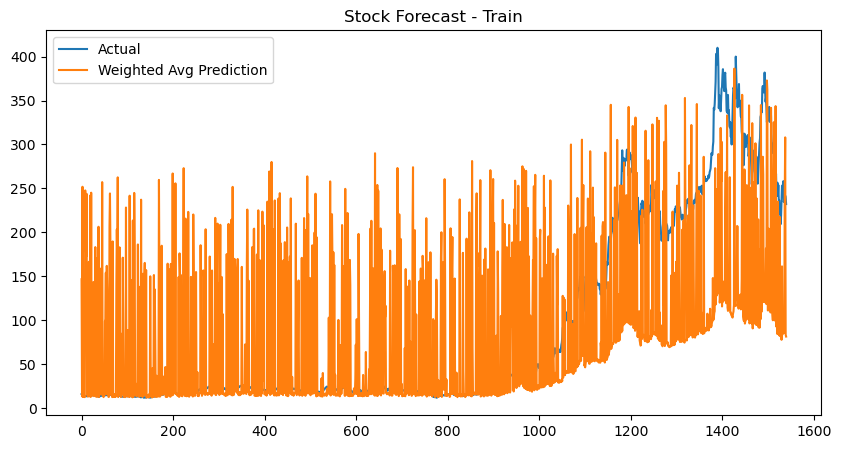

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, label="Actual")
plt.plot(ensemble_preds_train, label="Weighted Avg Prediction")
plt.title(f"{selected_dataset.title()} Forecast - Train")
plt.legend()
plt.show()

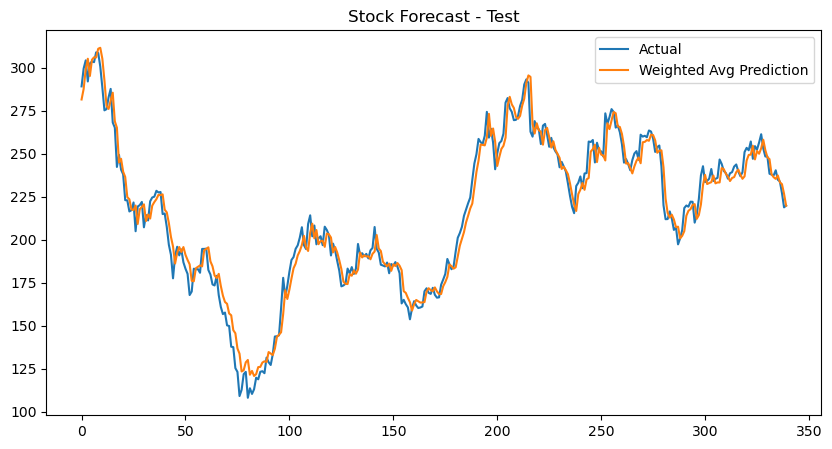

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual")
plt.plot(ensemble_preds_test, label="Weighted Avg Prediction")
plt.title(f"{selected_dataset.title()} Forecast - Test")
plt.legend()
plt.show()

In [15]:
model_rmses = []
for model in selected_models:
    with open(f"../{model}/RMSE_{model}.json", "r") as f:
        rmse_data = json.load(f)
    rmse = rmse_data[selected_dataset]
    model_rmses.append(rmse)

model_rmses.append(ensemble_rmse_test)

labels = [m for m in selected_models] + ['Weighted Averaging']

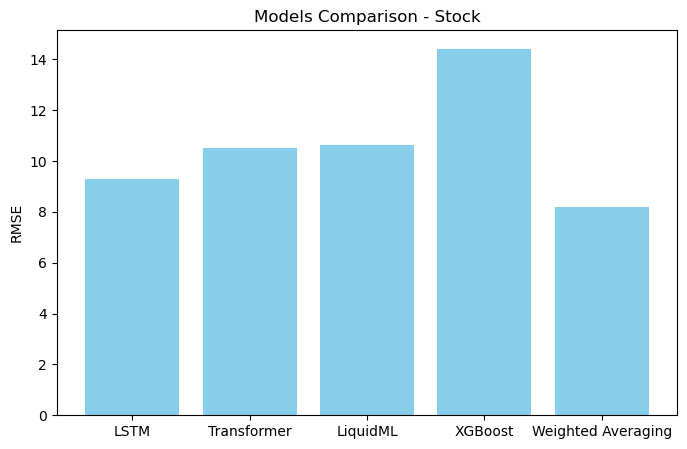

In [16]:
plt.figure(figsize=(8, 5))
plt.bar(labels, model_rmses, color='skyblue')
plt.title(f"Models Comparison - {selected_dataset.title()}")
plt.ylabel("RMSE")
plt.show()